<a href="https://colab.research.google.com/github/ahassanzadeh/SMS_CLASSIFICATION_LSTM_BERT/blob/main/SMS_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# change directory 
%cd /content/drive/MyDrive/Job_Interview/Companies/Amida/NLP_Data_Assessment

/content/drive/MyDrive/Job_Interview/Companies/Amida/NLP_Data_Assessment


In [ ]:
# list of files in the directory 
%ls

 Email_Classification.ipynb  'NLP Technical Assessment.docx'
 global_vector.txt            SMSSpamCollection.txt


In [ ]:
# general data science packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for text editing 
import re
import string

# sklearn package 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



In [ ]:
# install packages 
# Natural Language Toolkit
!pip install --user -U -q  nltk
# transofer package from hugging face library 
!pip install -q transformers 

In [ ]:
# import txt file as dataframe 
data = pd.read_csv('SMSSpamCollection.txt', sep="\t", header = None, encoding= 'latin-1') 

# naming the columns 
data.columns= ["Label", "Email"]

data.head()

,Label,Email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Label Encoding of the label column 

le = LabelEncoder()
le.fit(data['Label'])

data['Label'] = le.transform(data['Label'])
data.head()

,Label,Email
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.head()

,Label,Email
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.



In [ ]:
# drop null values 
print(len(data))
data.dropna(how="any", inplace=True, axis=1)
print(len(data))
# no null values 

5572
5572


In [ ]:
# find frequency of the two classes 
data.groupby('Label').describe()

Email                                                               
      count unique                                                top freq
Label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

Ad the data indicates, we have 5x more "Ham" than "Spam" class, which causes imbalanced class distribution in the dataset. 

# Pre-Processing 

# Cleaning 

In [ ]:

# This function clean the text to make it lowercase, remove question marks, brackets, punctuation, and numbers
def cleaning(text):
    # make text lowercase 
    text = str(text).lower()
    # remove question marks, brackets
    text = re.sub('\[.*?\]', '', text)
    # remove website name in the emails 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove punctuation 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove next line charchter 
    text = re.sub('\n', '', text)
    # remove numbers
    text = re.sub('\w*\d\w*', '', text)
    return text

data['ProcessedEmail'] = data['Email'].apply(cleaning)

# StopWords

In [ ]:
# ref: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) are removed 
stop_words = stopwords.words('english')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
data['ProcessedEmail'] = data['ProcessedEmail'].apply(remove_stopwords)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Label,Email,ProcessedEmail
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


## Stemming

removing the suffix from a word and reduce it to its root word. For example: “Flying” is a word and its suffix is “ing”, if we remove “ing” from “Flying” then we will get base word or root word which is “Fly”. 


In [ ]:
stemmer = nltk.SnowballStemmer("english")

# stemming function 
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

data['ProcessedEmail'] = data['ProcessedEmail'].apply(stemm_text)
data.head()

,Label,Email,ProcessedEmail
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [ ]:
# Split word in a sentence 
data['splited_word'] = data['ProcessedEmail'].str.split()
# Calculate the length of splitted words 
data['length_word'] = data['splited_word'].apply(len)
# maximum number of words in a sequence 
max_words = data['length_word'].max() # 80 

# Training with two major NLP models:

## 1-LSTM MODEL 

In [ ]:
# LSTM Packages 
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

In [ ]:
X = data['ProcessedEmail']
y = data['Label']
le = LabelEncoder()
Y_lstm = le.fit_transform(y)
# reshaping y to one column 
Y_lstm = Y_lstm.reshape(-1,1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2)

### Process the data
Tokenize the data and convert the text to sequences.
Add padding to ensure that all the sequences have the same shape.

In [ ]:
max_word = 1000 # max number of words in the dictionary 
max_len = 150 # maximum length of a sequence 
# This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) 
tok = Tokenizer(num_words=max_word)
# fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, 
# "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1, word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 
# Lower integer means more frequent word 
tok.fit_on_texts(X_train)
# Transforms each text in texts to a sequence of integers. it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
sequences = tok.texts_to_sequences(X_train)
# pad_sequences is used to ensure that all sequences in a list have the same length equal to the maximum length of sentences
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
def LSTM_arch():
    inputs = Input(name='inputs',shape=[max_len])
    # batch size is chosen 50 
    layer = Embedding(max_word,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    # 50 percent chance of bypassing the next layer 
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    # classfier activation 
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model_lstm = LSTM_arch()
model_lstm.summary()
#compares each of the predicted probabilities to actual class output which can be either 0 or 1. 
#It then calculates the score that penalizes the probabilities based on the distance from the expected value. That means how close or far from the actual value
# Accuracy = total number of correct predictions/total number of predictions 
model_lstm.compile(loss='binary_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [ ]:
history_lstm = model_lstm.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2)

Epoch 1/10
28/28 [==============================] - 7s 35ms/step - loss: 0.3702 - accuracy: 0.8597 - val_loss: 0.1938 - val_accuracy: 0.9395
Epoch 2/10
28/28 [==============================] - 0s 13ms/step - loss: 0.1308 - accuracy: 0.9658 - val_loss: 0.0725 - val_accuracy: 0.9798
Epoch 3/10
28/28 [==============================] - 0s 13ms/step - loss: 0.0629 - accuracy: 0.9820 - val_loss: 0.0510 - val_accuracy: 0.9854
Epoch 4/10
28/28 [==============================] - 0s 13ms/step - loss: 0.0409 - accuracy: 0.9877 - val_loss: 0.0500 - val_accuracy: 0.9843
Epoch 5/10
28/28 [==============================] - 0s 13ms/step - loss: 0.0327 - accuracy: 0.9902 - val_loss: 0.0718 - val_accuracy: 0.9742
Epoch 6/10
28/28 [==============================] - 0s 13ms/step - loss: 0.0279 - accuracy: 0.9919 - val_loss: 0.0514 - val_accuracy: 0.9865
Epoch 7/10
28/28 [==============================] - 0s 13ms/step - loss: 0.0213 - accuracy: 0.9935 - val_loss: 0.0642 - val_accuracy: 0.9865
Epoch 8/10
28

In [ ]:
# Function to draw learning curves 
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

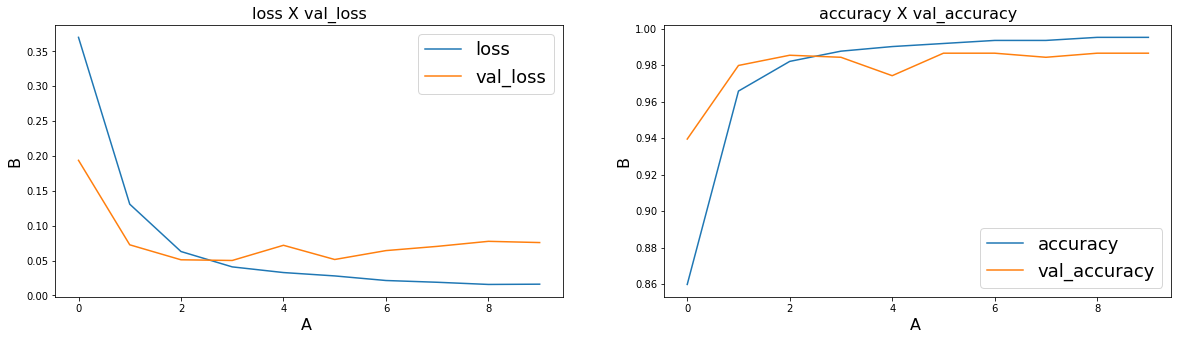

In [ ]:
# plot learning curve for loss and accuracy of training and validation data 
plot_learning_curves(history_lstm, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])


# Evaluation of LSTM Model on the test set 

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accuracy = model_lstm.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

35/35 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9821
Test set
  Loss: 0.083
  Accuracy: 0.982


## 2-BERT MODEL 


To train such a model, you mainly have to train the classifier, with minimal changes happening to the BERT model during the training phase. This training process is called Fine-Tuning

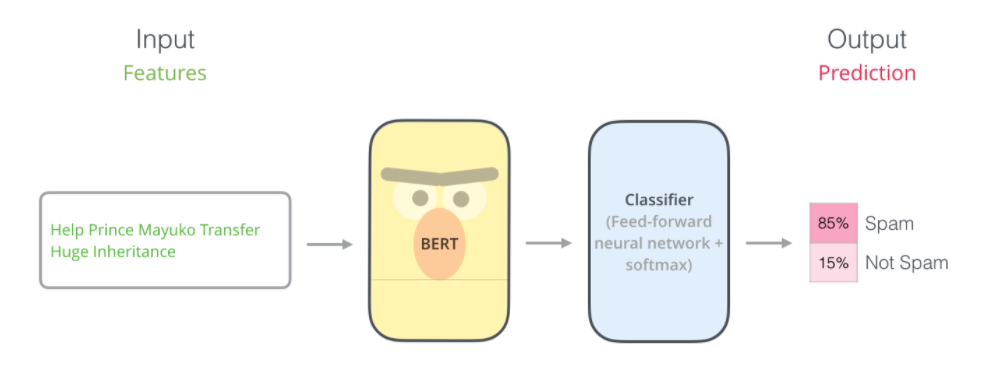

In [ ]:
# Deep Learning Packages  
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import TFBertModel
from transformers import BertTokenizer

from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
def encoder(data, maximum_length) :

    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            # Whether or not to add the special tokens associated with the corresponding model.
            add_special_tokens=True,
            # The maximum size of a sequence 
            max_length=maximum_length,
            # Padding 
            pad_to_max_length=True,
            # Return attention head for batch(parralization) 
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)


def bert_arch(bert_model):
    
    input_ids = tf.keras.Input(shape=(80,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(80,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    # take output of bert model (CLS)
    output = output[1]
    # Classifier (feed forward + sigmoid) 
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    # compares each of the predicted probabilities to actual class output which can be either 0 or 1. 
    # It then calculates the score that penalizes the probabilities based on the distance from the expected value. That means how close or far from the actual value
    # Accuracy = total number of correct predictions/total number of predictions 
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model



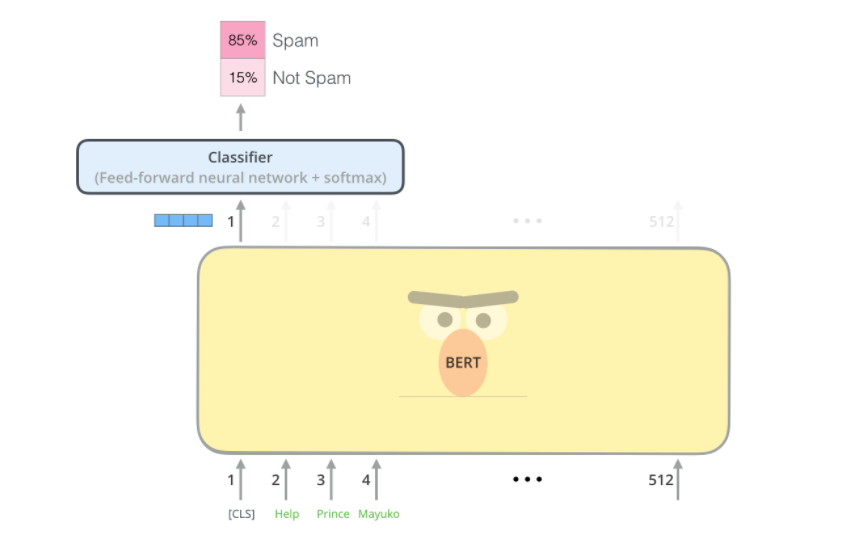

In [ ]:
# encoding the training data
# The input ids are token indices, numerical representations of tokens building the sequences that will be used as input by the model.
# The attention mask is an optional argument used when batching sequences together.
train_input_ids, train_attention_masks = encoder(X,max_words)
# pretraining Large BERT with 24 encoder, not case sensetive 
pre_trained_bert_encoder = TFBertModel.from_pretrained('bert-large-uncased')
# Create BERT model with NN architure
model_bert = bert_arch(pre_trained_bert_encoder)
model_bert.summary()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]        

In [ ]:
history_bert = model_bert.fit(
    [train_input_ids, train_attention_masks],
    y,
    validation_split=0.2, 
    epochs= 10,
    batch_size=10
)


Epoch 1/10
446/446 [==============================] - 215s 402ms/step - loss: 0.1946 - accuracy: 0.9289 - val_loss: 0.1259 - val_accuracy: 0.9668
Epoch 2/10
446/446 [==============================] - 173s 388ms/step - loss: 0.0860 - accuracy: 0.9782 - val_loss: 0.0637 - val_accuracy: 0.9821
Epoch 3/10
446/446 [==============================] - 173s 389ms/step - loss: 0.0702 - accuracy: 0.9843 - val_loss: 0.0799 - val_accuracy: 0.9713
Epoch 4/10
446/446 [==============================] - 173s 389ms/step - loss: 0.0424 - accuracy: 0.9906 - val_loss: 0.0656 - val_accuracy: 0.9776
Epoch 5/10
446/446 [==============================] - 173s 388ms/step - loss: 0.0426 - accuracy: 0.9908 - val_loss: 0.0695 - val_accuracy: 0.9821
Epoch 6/10
446/446 [==============================] - 173s 389ms/step - loss: 0.0279 - accuracy: 0.9939 - val_loss: 0.0572 - val_accuracy: 0.9830
Epoch 7/10
446/446 [==============================] - 173s 388ms/step - loss: 0.0141 - accuracy: 0.9948 - val_loss: 0.0811 -

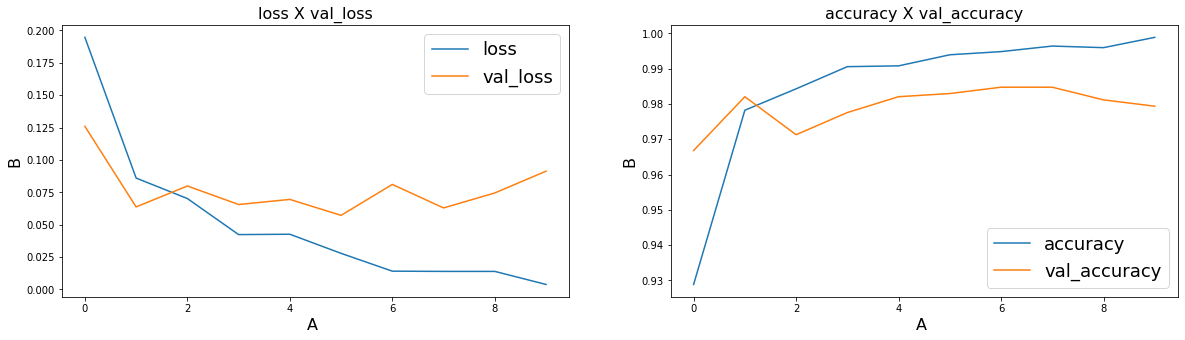

In [ ]:
plot_learning_curves(history_bert, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])


# Evaluation of Bert model on the test set 

In [ ]:
train_input_ids, train_attention_masks = encoder(X_test,max_words)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
accuracy = model_bert.evaluate([train_input_ids, train_attention_masks], Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

35/35 [==============================] - 12s 344ms/step - loss: 0.0284 - accuracy: 0.9937
Test set
  Loss: 0.028
  Accuracy: 0.994


**It can be deducted that BERT model with fewer training epochs have better performance than LSTM model.**